# Importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import keras
import random as rnd
import pathlib
import math
import re
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential as sequential
from tensorflow.keras import applications as pretrained
from tensorflow.python.client import device_lib
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.utils import plot_model

# --- Processor option ---
# GPU setup
try:
    gpu = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu[0], True)
except:
    print("None of GPUs are detected")

In [2]:
folderPath = "../input/alien-vs-predator-images/data/"
trainPath =  pathlib.Path("".join([folderPath,"train/"]))
imgList = list(trainPath.glob("*/*.jpg"))
avgWidth = 0
avgHeight = 0
for i in range(len(imgList)):
  img = PIL.Image.open(imgList[i])
  avgWidth += img.size[0]
  avgHeight += img.size[1]
avgWidth = round(avgWidth/len(imgList), 3)
avgHeight = round(avgHeight/len(imgList), 3)
print('Average width : {0}\nAverage height : {1}\nTrain samples : {2}'.format(avgWidth, avgHeight, len(imgList)))

Average width : 249.558
Average height : 209.298
Train samples : 694


# Loading the dataset

**With 'tf.keras.preprocessing.image_dataset_from_directory', easily loading the dataset.**

In [3]:
# About total images * 1%
batch_size = 8
# Setting image size based on avg. image size 
img_width = 224
img_height = 224
inputTensor = tf.keras.Input(shape=(img_width,img_height,3))

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "".join([folderPath,"train/"]),
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="binary",
  color_mode="rgb",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "".join([folderPath,"validation/"]),
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="binary",
  color_mode="rgb",
)
class_names = train_ds.class_names
print(class_names)

Found 694 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
['alien', 'predator']


**Image examples**

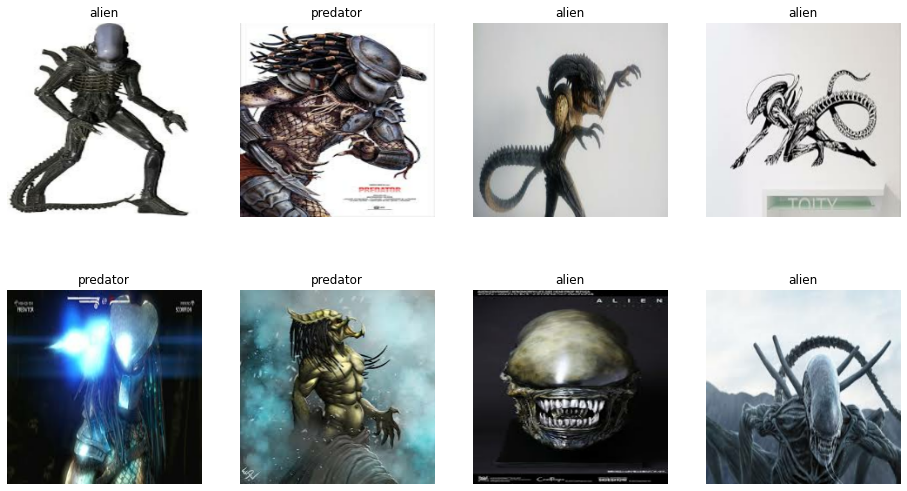

In [4]:
plt.figure(figsize=(16, 9))
for images, labels in train_ds.take(1):
    for i in range(batch_size):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# Setting for the preprocessing

**For the argumentation, I used the layers in Tensorflow tutorial page.**

In [5]:
cut_off = 0.5
epochs = 100

# Defining the data argumentation
data_augmentation = sequential(
  [
    layers.experimental.preprocessing.RandomFlip(input_shape=(img_height, img_width, 3), mode="horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
  , name="Argumentation"
)
data_augmentation.summary()

metricsVec = [
  metrics.BinaryAccuracy(threshold=cut_off),
  metrics.Precision(thresholds=cut_off),
  metrics.Recall(thresholds=cut_off),
  metrics.AUC()
]

# F1 = 2*((precision*recall)/(precision+recall))
modelVec = ['ResNet152V2', 'InceptionResNetV2', 'Xception', 'DenseNet201', 'NasNetMobile', "MobileNetV3Large", "EfficientNetB6"]
result = pd.DataFrame({'Accuracy' : [None]*len(modelVec),
       'F1' : [None]*len(modelVec),
       'AUC' : [None]*len(modelVec),
       'Loss' : [None]*len(modelVec),
       'Epoch' : [None]*len(modelVec)                
})
result.index = modelVec
print(result)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Model: "Argumentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
                  Accuracy    F1   AUC  Loss Epoch
ResNet152V2           None  None  None  None  None
InceptionResNetV2     None  None  None  None  None
Xception              None  None  None  None  None
DenseNet201           None  None  None  None  None
NasNetMobile          None  None  None  None  None
MobileNetV3Large      None  None  None  None  None
EfficientNetB6        None  None

**Argumentation examples**

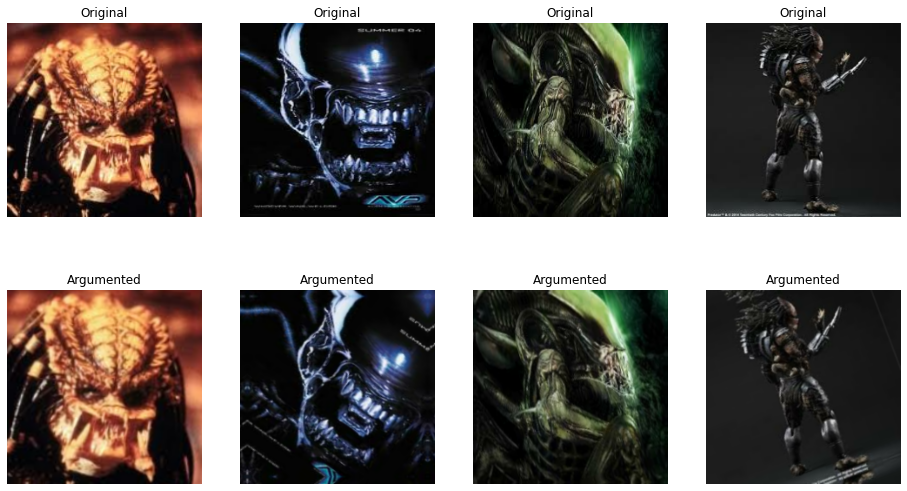

In [6]:
plt.figure(figsize=(16, 9))
for images, labels in train_ds.take(1):
#     Insert images into the argumetation layer
    argImg = data_augmentation(images)
    for i in range(int(batch_size/2)):
       
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 4, i + 1 + int(batch_size/2))
        plt.imshow(argImg[i].numpy().astype("uint8"))
        plt.title("Argumented")
        plt.axis("off")

# Defining the functions for creating some models

**On top layer, I stacked the 'GlobalAveragePooling2D' layer which is followed by the 'Dropout(0.2)' layer and sigmoid classifier.**

**I set 10 steps for early stopping (epochs*10%)**

**Since MobileNet and EfficientNet have own rescaling layer, I didn't add the layer in those models.**

In [7]:
def CreatingTopLayers(featureTensor):
    topLayers = None
    topLayers = sequential([
                    layers.GlobalAveragePooling2D(),
                    layers.Dropout(0.2),
                    layers.Dense(units=1, activation="sigmoid")
    ], name="Top_Layers")
    return(topLayers)

# Creating the pretrained CNN models
def CreatingModels(model_name):
  modified_model = None
  if model_name == "ResNet50V2":
    # Loading the base model
    model_base = sequential([
      layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.ResNet50V2(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_ResNet50V2")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="ResNet50V2")
    modified_model.summary()
  
  if model_name == "ResNet152V2":
    # Loading the base model
    model_base = sequential([
      layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.ResNet152V2(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_ResNet152V2")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="ResNet152V2")
    modified_model.summary()


  elif model_name == "InceptionResNetV2":
    # Loading the base model
    model_base = sequential([
      layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.InceptionResNetV2(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_InceptionResNetV2")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="InceptionResNetV2")
    modified_model.summary()

  elif model_name == "Xception":
    # Loading the base model
    model_base = sequential([
      layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.Xception(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_Xception")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="Xception")
    modified_model.summary()

  elif model_name == "DenseNet201":
    # Loading the base model
    model_base = sequential([
      layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.DenseNet201(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_DenseNet201")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="DenseNet201")
    modified_model.summary()

  elif model_name == "NasNetMobile":
    # Loading the base model
    model_base = sequential([
      layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.NASNetMobile(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_NasNetMobile")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="NasNetMobile")
    modified_model.summary()

  elif model_name == "MobileNetV3Small":
    # Loading the base model
    model_base = sequential([
      # layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.MobileNetV3Small(input_shape=(img_height, img_width, 3), weights="imagenet", alpha=1.0, include_top=False)
    ], name="Base_MobileNetV3Small")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="MobileNetV3Small")
    modified_model.summary()

  elif model_name == "MobileNetV3LargeMini":
    # Loading the base model
    model_base = sequential([
      # layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.MobileNetV3Large(input_shape=(img_height, img_width, 3), weights="imagenet", minimalistic=True, alpha=1.0, include_top=False)
    ], name="Base_MobileNetV3LargeMini")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="MobileNetV3LargeMini")
    modified_model.summary()

  elif model_name == "MobileNetV3Large":
    # Loading the base model
    model_base = sequential([
      # layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
      data_augmentation,
      pretrained.MobileNetV3Large(input_shape=(img_height, img_width, 3), weights="imagenet", minimalistic=False, alpha=1.0, include_top=False)
    ], name="Base_MobileNetV3Large")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="MobileNetV3Large")
    modified_model.summary()

  elif model_name == "EfficientNetB4":
    # Loading the base model
    model_base = sequential([
      # layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1 / 255, name="Rescailing"),
      data_augmentation,
      pretrained.EfficientNetB4(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_EfficientNetB4")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="EfficientNetB4")
    modified_model.summary()
  
  elif model_name == "EfficientNetB6":
    # Loading the base model
    model_base = sequential([
      # layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1 / 255, name="Rescailing"),
      data_augmentation,
      pretrained.EfficientNetB6(input_shape=(img_height, img_width, 3), weights="imagenet", include_top=False)
    ], name="Base_EfficientNetB6")
    model_base.trainable = False
    model_base.summary()

    featureTensor = model_base(inputTensor)
    topLayers = CreatingTopLayers(featureTensor)

    modified_model = sequential([
      model_base,
      topLayers
    ], name="EfficientNetB6")
    modified_model.summary()

  modified_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001*3),
                         loss=losses.BinaryCrossentropy(from_logits=False),
                         metrics=metricsVec
                         )
  return (modified_model)

def PlotingResult(his, result, name):
  acc = his.history['binary_accuracy']
  val_acc = his.history['val_binary_accuracy']
  loss = his.history['loss']
  val_loss = his.history['val_loss']

  plt.figure(figsize=(16, 9))
  plt.rc('font', size=12)

  plt.subplot(1, 2, 1)
  plt.plot(range(len(acc)), acc, label='Training Accuracy')
  plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
  plt.legend(loc='upper left')
  title = 'Training and Validation Accuracy (' + his.model.name + ')'
  plt.title(title)

  plt.subplot(1, 2, 2)
  plt.plot(range(len(loss)), loss, label='Training Loss')
  plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  title = 'Training and Validation Loss (' + his.model.name + ')'
  plt.title(title)
  plt.show()

  bestIdx = 0
  val_accuracy = 0
  val_precision = 0
  val_recall = 0
  val_auc = 0
  val_f1 = 0

  for i,j in his.history.items():
    if "val_loss" in i:
      bestIdx = np.argmin(j)
      val_loss = j[-1]

  for i,j in his.history.items():
    if "val_binary_accuracy" in i:
      val_accuracy = j[-1]
    elif "val_precision" in i:
      val_precision = j[-1]
    elif "val_recall" in i:
      val_recall = j[-1]
    elif "val_auc" in i:
      val_auc = j[-1]
  val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
  
  result.iloc[result.index.tolist().index(name)] = [val_accuracy, val_f1, val_auc, val_loss, len(his.epoch)]
  return(result)

def SquareRootScheduler(epochCount, lr): return lr * pow(epochCount+1.0, -0.5)
cb_lrscheduler = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler)
cb_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=math.floor(epochs*0.1))

# Learning scheduler

**I let the existing learning curved for speeding up learning.**

Text(0, 0.5, 'Learning rate')

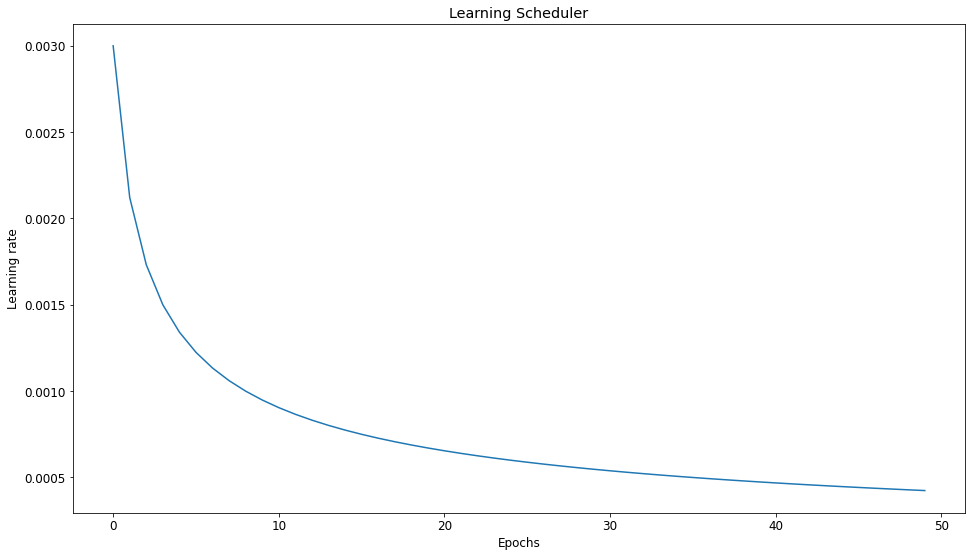

In [8]:
tmpEpochs = list(range(50))
tmpLr = list(map(lambda x: SquareRootScheduler(x, tf.keras.optimizers.Adam().get_config()["learning_rate"]*3), tmpEpochs))

plt.figure(figsize=(16, 9))
plt.rc('font', size=12)
plt.plot(tmpEpochs, tmpLr, label='Training Accuracy')
plt.title("Learning Scheduler")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")

# ResNet152 V2

ResNet152V2
234553344/234545216 [==============================] - 1s 0us/step
Model: "Base_ResNet152V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescailing (Rescaling)       (None, 224, 224, 3)       0         
_________________________________________________________________
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
Total params: 58,331,648
Trainable params: 0
Non-trainable params: 58,331,648
_________________________________________________________________
Model: "ResNet152V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_ResNet152V2 (Sequential (None, 7, 7, 2048)        58331648  
_________________________________________________________________
Top_

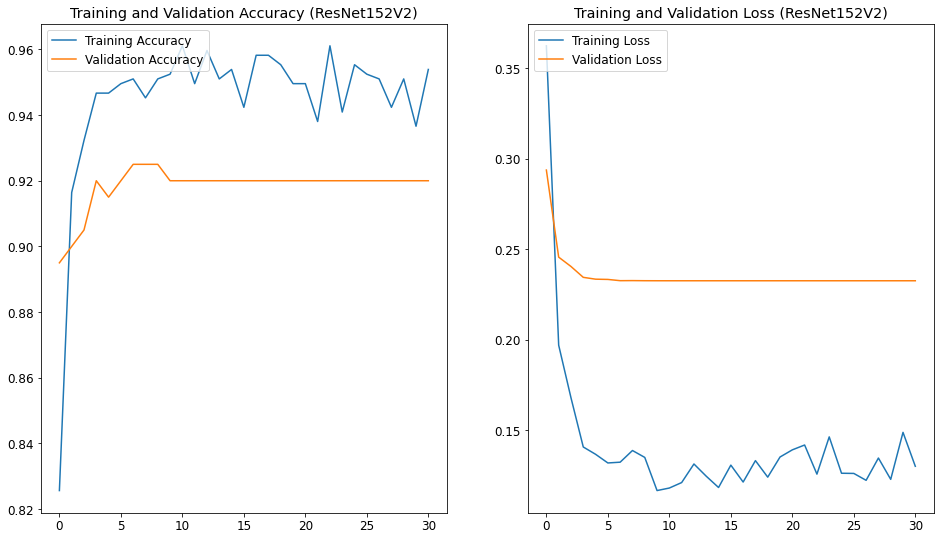

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,None,None,None,None,None
Xception,None,None,None,None,None
DenseNet201,None,None,None,None,None
NasNetMobile,None,None,None,None,None
MobileNetV3Large,None,None,None,None,None
EfficientNetB6,None,None,None,None,None


In [9]:
# ResNet152V2
print(modelVec[0])
tf.random.set_seed(2000)
model_resnet152v2 = None
model_resnet152v2 = CreatingModels(modelVec[0])
history_resnet152v2 = None
history_resnet152v2 = model_resnet152v2.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_resnet152v2, result, modelVec[0])
result

# InceptionResNet V2

InceptionResNetV2
219062272/219055592 [==============================] - 1s 0us/step
Model: "Base_InceptionResNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescailing (Rescaling)       (None, 224, 224, 3)       0         
_________________________________________________________________
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
Total params: 54,336,736
Trainable params: 0
Non-trainable params: 54,336,736
_________________________________________________________________
Model: "InceptionResNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_InceptionResNetV2 (Sequ (None, 5, 5, 1536)        54336736  
____________________________________________________

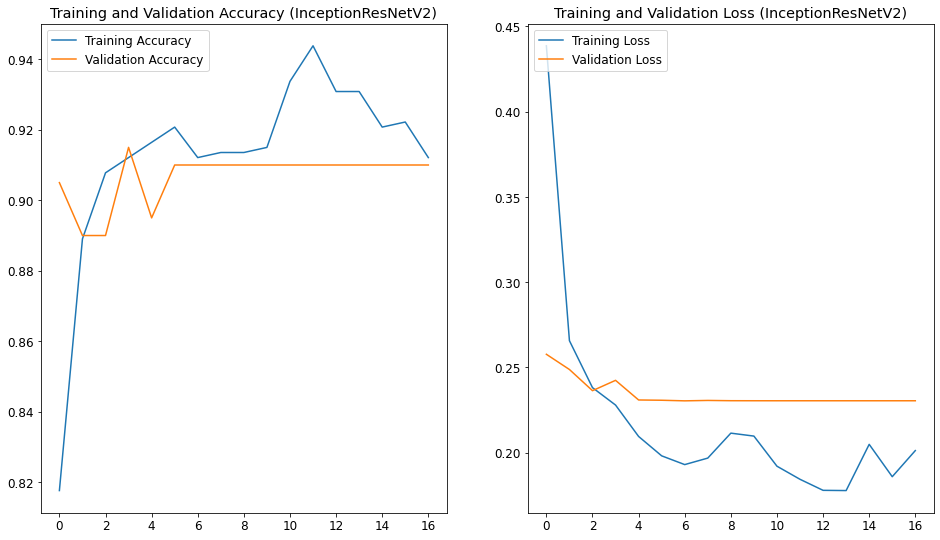

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,0.91,0.908163,0.96585,0.230385,17
Xception,None,None,None,None,None
DenseNet201,None,None,None,None,None
NasNetMobile,None,None,None,None,None
MobileNetV3Large,None,None,None,None,None
EfficientNetB6,None,None,None,None,None


In [10]:
# InceptionResNetV2
print(modelVec[1])
tf.random.set_seed(2000)
model_inceptionResnetv2 = None
model_inceptionResnetv2 = CreatingModels(modelVec[1])
history_inceptionResnetv2 = None
history_inceptionResnetv2 = model_inceptionResnetv2.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_inceptionResnetv2, result, modelVec[1])
result

# Xception

Xception
83689472/83683744 [==============================] - 1s 0us/step
Model: "Base_Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescailing (Rescaling)       (None, 224, 224, 3)       0         
_________________________________________________________________
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
_________________________________________________________________
Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_Xception (Sequential)   (None, 7, 7, 2048)        20861480  
_________________________________________________________________
Top_Layers (Seq

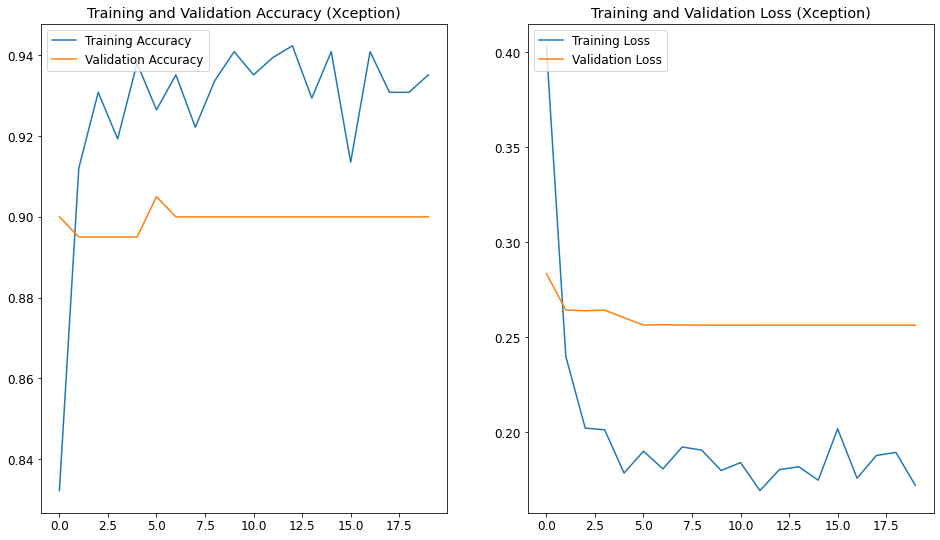

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,0.91,0.908163,0.96585,0.230385,17
Xception,0.9,0.901961,0.9597,0.256282,20
DenseNet201,None,None,None,None,None
NasNetMobile,None,None,None,None,None
MobileNetV3Large,None,None,None,None,None
EfficientNetB6,None,None,None,None,None


In [11]:
# Xception
print(modelVec[2])
tf.random.set_seed(2000)
model_xception = None
model_xception = CreatingModels(modelVec[2])
history_xception = None
history_xception = model_xception.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_xception, result, modelVec[2])
result

# DensNet201

DenseNet201
74842112/74836368 [==============================] - 1s 0us/step
Model: "Base_DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescailing (Rescaling)       (None, 224, 224, 3)       0         
_________________________________________________________________
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
_________________________________________________________________
Model: "DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_DenseNet201 (Sequential (None, 7, 7, 1920)        18321984  
_________________________________________________________________
Top_La

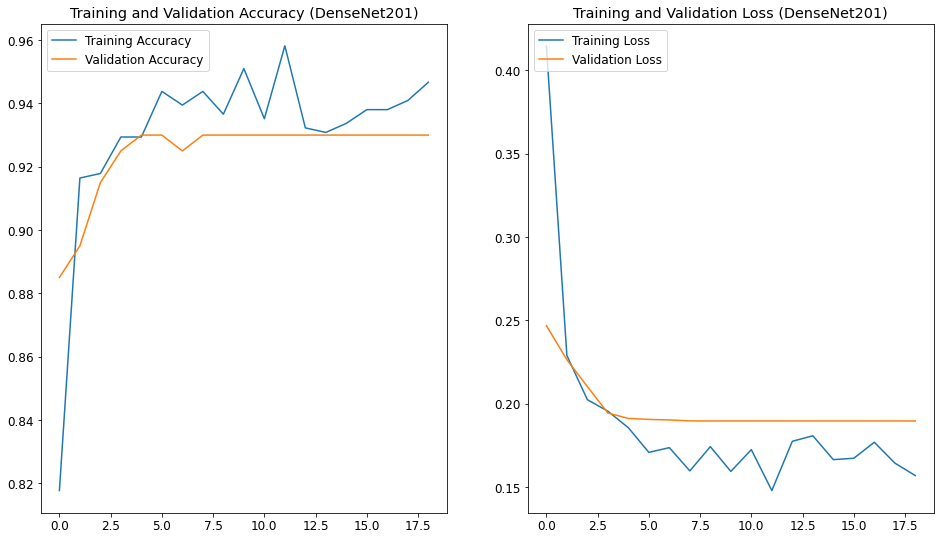

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,0.91,0.908163,0.96585,0.230385,17
Xception,0.9,0.901961,0.9597,0.256282,20
DenseNet201,0.93,0.929293,0.97865,0.189552,19
NasNetMobile,None,None,None,None,None
MobileNetV3Large,None,None,None,None,None
EfficientNetB6,None,None,None,None,None


In [12]:
# DenseNet201
print(modelVec[3])
tf.random.set_seed(2000)
model_DenseNet201 = None
model_DenseNet201 = CreatingModels(modelVec[3])
history_DenseNet201 = None
history_DenseNet201 = model_DenseNet201.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_DenseNet201, result, modelVec[3])
result

# NasNetMobile

NasNetMobile
19996672/19993432 [==============================] - 0s 0us/step
Model: "Base_NasNetMobile"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescailing (Rescaling)       (None, 224, 224, 3)       0         
_________________________________________________________________
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
Total params: 4,269,716
Trainable params: 0
Non-trainable params: 4,269,716
_________________________________________________________________
Model: "NasNetMobile"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_NasNetMobile (Sequentia (None, 7, 7, 1056)        4269716   
_________________________________________________________________
Top_L

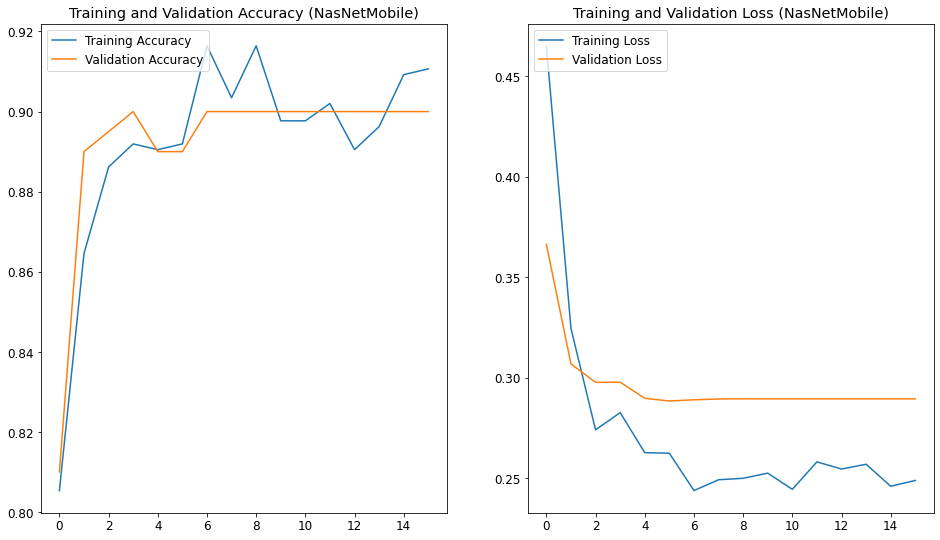

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,0.91,0.908163,0.96585,0.230385,17
Xception,0.9,0.901961,0.9597,0.256282,20
DenseNet201,0.93,0.929293,0.97865,0.189552,19
NasNetMobile,0.9,0.901961,0.9497,0.289527,16
MobileNetV3Large,None,None,None,None,None
EfficientNetB6,None,None,None,None,None


In [13]:
# NasNetMobile
print(modelVec[4])
tf.random.set_seed(2000)
model_nasnetMobile = None
model_nasnetMobile = CreatingModels(modelVec[4])
history_nasnetMobile = None
history_nasnetMobile = model_nasnetMobile.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_nasnetMobile, result, modelVec[4])
result

# MobileNet V3 Large

MobileNetV3Large
17612800/17605208 [==============================] - 0s 0us/step
Model: "Base_MobileNetV3Large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
Total params: 4,226,432
Trainable params: 0
Non-trainable params: 4,226,432
_________________________________________________________________
Model: "MobileNetV3Large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_MobileNetV3Large (Seque (None, 7, 7, 1280)        4226432   
_________________________________________________________________
Top_Layers (Sequential)      (None, 1)                 1281      
Total params: 4,227,713
Trainable params: 1,281
Non-trainab

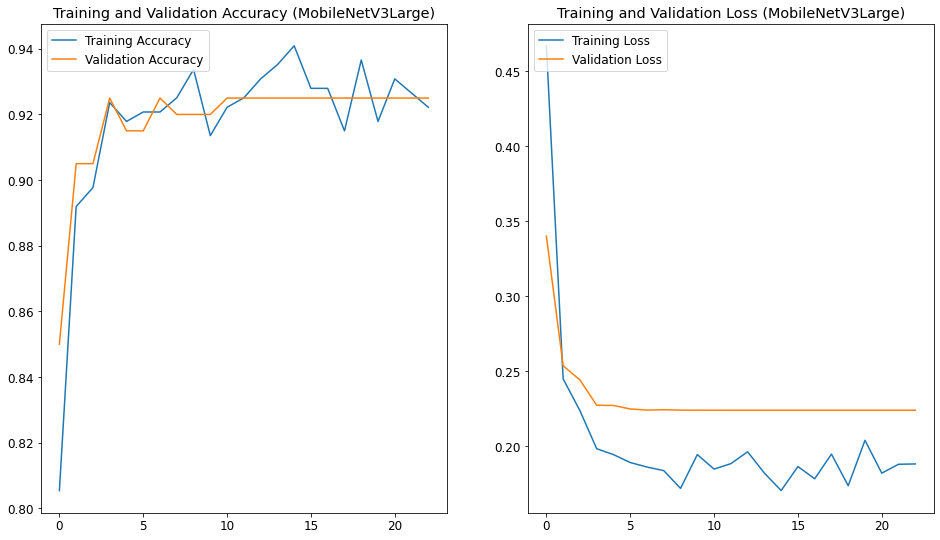

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,0.91,0.908163,0.96585,0.230385,17
Xception,0.9,0.901961,0.9597,0.256282,20
DenseNet201,0.93,0.929293,0.97865,0.189552,19
NasNetMobile,0.9,0.901961,0.9497,0.289527,16
MobileNetV3Large,0.925,0.925373,0.9709,0.224112,23
EfficientNetB6,None,None,None,None,None


In [14]:
# MobileNetV3Large
print(modelVec[5])
tf.random.set_seed(2000)
model_mobilenetv3large = None
model_mobilenetv3large = CreatingModels(modelVec[5])
history_mobilenetv3large = None
history_mobilenetv3large = model_mobilenetv3large.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_mobilenetv3large, result, modelVec[5])
result

# EfficientNet B6

EfficientNetB6
165240832/165234480 [==============================] - 1s 0us/step
Model: "Base_EfficientNetB6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Argumentation (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
Total params: 40,960,143
Trainable params: 0
Non-trainable params: 40,960,143
_________________________________________________________________
Model: "EfficientNetB6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Base_EfficientNetB6 (Sequent (None, 7, 7, 2304)        40960143  
_________________________________________________________________
Top_Layers (Sequential)      (None, 1)                 2305      
Total params: 40,962,448
Trainable params: 2,305
Non-trainabl

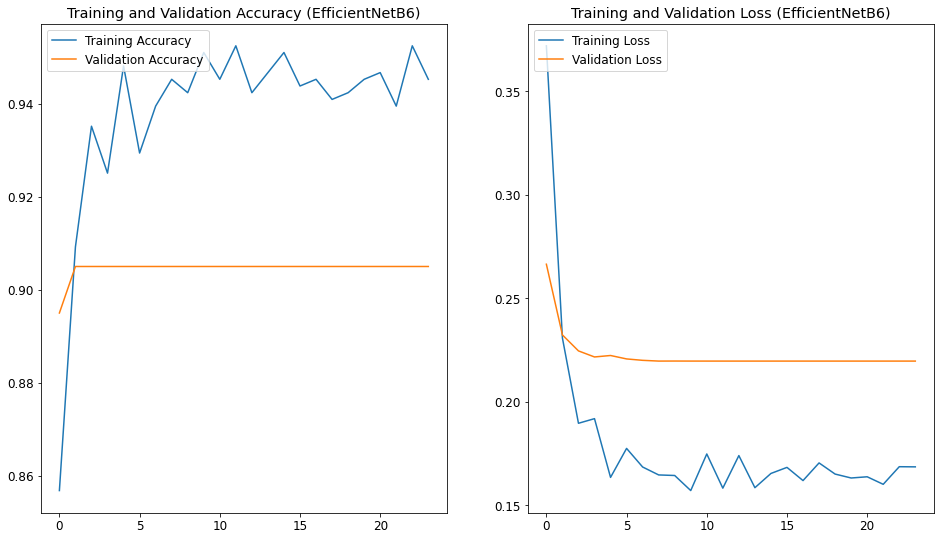

,Accuracy,F1,AUC,Loss,Epoch
ResNet152V2,0.92,0.919192,0.9698,0.232607,31
InceptionResNetV2,0.91,0.908163,0.96585,0.230385,17
Xception,0.9,0.901961,0.9597,0.256282,20
DenseNet201,0.93,0.929293,0.97865,0.189552,19
NasNetMobile,0.9,0.901961,0.9497,0.289527,16
MobileNetV3Large,0.925,0.925373,0.9709,0.224112,23
EfficientNetB6,0.905,0.907317,0.9731,0.21955,24


In [15]:
# EfficientNetB6
print(modelVec[6])
tf.random.set_seed(2000)
model_efficientnetb6 = None
model_efficientnetb6 = CreatingModels(modelVec[6])
history_efficientnetb6 = None
history_efficientnetb6 = model_efficientnetb6.fit(
  train_ds,
  batch_size=None,
  validation_data=val_ds,
  validation_batch_size=None,
  epochs=epochs,
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)
result = PlotingResult(history_efficientnetb6, result, modelVec[6])
result

**Summary**

1. I used models of which parameters are in 40mil ~ 60mil. 

2. 'DenseNet201' shows the best performance with accuracy = 91.5% and loss = 0.184.